# Dog Breeds Convolutional Classificator with TensorFlow

## Импорт библиотек

In [1]:
from google.colab import drive
import shutil
import zipfile
import os
import pathlib
from PIL import Image
import tensorflow as tf
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt
import pandas as pd

tf.test.gpu_device_name()

'/device:GPU:0'

## Подключение GoogleDrive (Для Google Colab)

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


## Загрузка набора данных из GoogleDrive


In [4]:
zip_file_path = '/content/drive/MyDrive/Datasets/StanfordDogs.zip'
shutil.copy(zip_file_path, '/content/')

unzip_dir = '/content/StanfordDogs/'
with zipfile.ZipFile('/content/StanfordDogs.zip', 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

print(os.listdir(unzip_dir))

['annotations', 'images']


## Валидация данных

In [5]:
def check_images(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg'):
                filepath = os.path.join(root, file)
                try:
                    img_raw = tf.io.read_file(filepath)
                    img = tf.io.decode_image(img_raw, channels=3)
                    img_jpeg = tf.io.encode_jpeg(tf.cast(img, tf.uint8))
                except (tf.errors.InvalidArgumentError, ValueError) as e:
                    print(f'Error with image {filepath}: {e}')
                    os.remove(filepath)  # Удаление проблемного изображения
    print('All images are fine')


check_images(unzip_dir)

All images are fine


## Разбиение и загрузка данных

In [6]:
train_dataset = keras.preprocessing.image_dataset_from_directory(
    '/content/StanfordDogs/images/Images',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    validation_split=0.2,
    subset='training',
    seed=1488
)

validation_dataset = keras.preprocessing.image_dataset_from_directory(
    '/content/StanfordDogs/images/Images',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    validation_split=0.2,
    subset='validation',
    seed=1488
)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


## Построение модели

Модель будет дообучаться на базовой модели, обученной на основе набора данных ImageNet.

In [81]:
base_model = keras.applications.MobileNetV3Large(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
print(f'Base model (No top) layers count: {len(base_model.layers)}')

Base model (No top) layers count: 187


In [82]:
base_model.trainable = False

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.2),
    keras.layers.RandomContrast(0.1),
    keras.layers.RandomBrightness(0.2)
])

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(120, activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_36 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_12 (Sequential)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Large (Functional)        │ (None, 7, 7, 960)           │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_12          │ (None, 960)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 256)                 │         246,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 120)                 │          30,840 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,273,208 (12.49 MB)

 Trainable params: 276,856 (1.06 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

## Компиляция модели

In [83]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

## Создание обратных вызовов

In [84]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/Models/dogbreeds.keras',
        save_best_only=True
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
		patience=3
    )
]

## Обучение модели

In [85]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 48s 80ms/step - accuracy: 0.2554 - loss: 3.3162 - val_accuracy: 0.7388 - val_loss: 0.8475
Epoch 2/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.5879 - loss: 1.4416 - val_accuracy: 0.7668 - val_loss: 0.7523
Epoch 3/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 82s 80ms/step - accuracy: 0.6328 - loss: 1.2561 - val_accuracy: 0.7758 - val_loss: 0.7202
Epoch 4/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 82s 80ms/step - accuracy: 0.6638 - loss: 1.1468 - val_accuracy: 0.7750 - val_loss: 0.7160
Epoch 5/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 83s 82ms/step - accuracy: 0.6733 - loss: 1.0858 - val_accuracy: 0.7818 - val_loss: 0.7099
Epoch 6/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 39s 75ms/step - accuracy: 0.6814 - loss: 1.0490 - val_accuracy: 0.7813 - val_loss: 0.6983
Epoch 7/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 41s 75ms/step - accuracy: 0.6985 - loss: 0.9897 - val_accuracy: 0.7869 - val_loss: 0.6970
Epoch 8/50
515/515 ━━━━━━━━━━━━━━━━━━━━ 40s 72ms/step - accuracy: 0.7073 - loss: 0.9598 - 

## Визуализация обучения

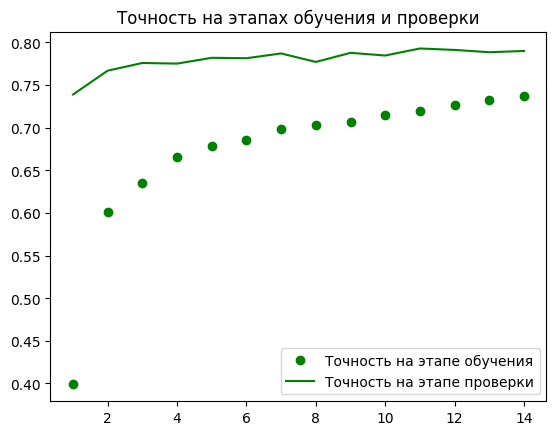

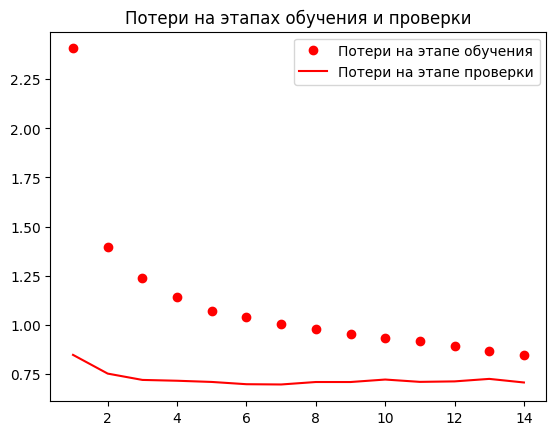

In [86]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'go', label='Точность на этапе обучения')
plt.plot(epochs, val_accuracy, 'g', label='Точность на этапе проверки')
plt.title('Точность на этапах обучения и проверки')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Потери на этапе обучения')
plt.plot(epochs, val_loss, 'r', label='Потери на этапе проверки')
plt.title('Потери на этапах обучения и проверки')
plt.legend()
plt.show()

## Тестирование модели

In [87]:
test_model = keras.models.load_model('/content/drive/MyDrive/Models/dogbreeds.keras')
test_loss, test_acc = test_model.evaluate(validation_dataset)
print(f'Test accuracy: {test_acc:.3f}')

129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.7832 - loss: 0.7287
Test accuracy: 0.787


## Просмотр формата предсказаний

In [88]:
prediction = test_model.predict(validation_dataset.take(1))
print(f'Prediction format: {prediction}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediction format: [[5.47423546e-08 8.66436506e-11 6.82689794e-15 ... 2.54475302e-10
  8.87687424e-11 1.09170702e-11]
 [5.56816522e-05 7.73074978e-04 1.35648949e-02 ... 1.39381381e-10
  9.47660506e-10 1.48788792e-09]
 [2.95342176e-07 4.03091838e-10 3.63930891e-12 ... 6.83959822e-09
  9.86021078e-08 2.95835634e-10]
 ...
 [1.19742625e-08 1.68604697e-09 3.04419823e-09 ... 2.40905247e-11
  2.01049621e-09 2.34049360e-11]
 [9.94145388e-09 2.58339099e-07 1.89257410e-09 ... 8.40905567e-09
  8.73449535e-10 6.78520422e-08]
 [6.78576271e-07 2.02800976e-08 1.03241170e-03 ... 8.54651593e-12
  3.30346167e-10 3.18466115e-10]]


## Сохранение списка меток

In [89]:
class_names = train_dataset.class_names
classes_df = pd.DataFrame(class_names, columns=['Classes'])
classes_df.to_csv('/content/drive/MyDrive/Models/Labels/dogbreeds.csv', index=False)